# Preprocessing & Statistics

In [29]:
# Setup: importa moduli e determina i percorsi (usa conf se presente)
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Prova a trovare la root 'cellPIV' come nello script originale
cwd = Path().resolve()
root = cwd
for _ in range(10):
    if root.name == 'cellPIV':
        break
    if root.parent == root:
        break
    root = root.parent

# fallback: usa il percorso fornito dall'utente nello script
fallback_root = Path('/home/phd2/Scrivania/CorsoRepo/cellPIV')
if root.name != 'cellPIV':
    root = fallback_root

# aggiungi root al sys.path per poter importare config se disponibile
if str(root) not in sys.path:
    sys.path.append(str(root))

print('Using root:', root)

# prova a importare la config (come nello script)
try:
    from config import Config_00_preprocessing as conf
    print('Imported conf from config.Config_00_preprocessing')
except Exception as e:
    conf = None
    print('Could not import conf (ok). Please set paths manually if needed.')

# Imposta i percorsi (fallback coerenti con lo script)
base_dir = Path(conf.path_original_excel).parent if conf and hasattr(conf, 'path_original_excel') else Path('/home/phd2/Scrivania/CorsoRepo/cellPIV/_00b_preprocessing_excels')
path_input_excel = Path(getattr(conf, 'path_original_excel', base_dir / 'original.xlsx'))
path_double_dish = Path(getattr(conf, 'path_double_dish_excel', base_dir / 'double_dish.xlsx'))
path_added_id = Path(getattr(conf, 'path_addedID_csv', base_dir / 'added_id.csv'))
path_valid_wells = Path(getattr(conf, 'valid_wells_file', base_dir / 'datasets/valid_wells_acquisition_times.csv'))
path_filtered = Path(getattr(conf, 'filtered_blasto_dataset', base_dir / 'filtered_table.csv'))

print('Paths:')
print(' input_excel ->', path_input_excel)
print(' double_dish ->', path_double_dish)
print(' added_id CSV ->', path_added_id)
print(' valid_wells CSV ->', path_valid_wells)
print(' filtered output ->', path_filtered)

# Display inline plots
%matplotlib inline


Using root: /home/phd2/Scrivania/CorsoRepo/cellPIV
Imported conf from config.Config_00_preprocessing
Paths:
 input_excel -> /home/phd2/Scrivania/CorsoRepo/cellPIV/datasets/DB morpheus UniPV.xlsx
 double_dish -> /home/phd2/Scrivania/CorsoRepo/cellPIV/datasets/pz con doppia dish.xlsx
 added_id CSV -> /home/phd2/Scrivania/CorsoRepo/cellPIV/datasets/DB_Morpheus_withID.csv
 valid_wells CSV -> /home/phd2/Scrivania/CorsoRepo/cellPIV/datasets/valid_wells_acquisition_times.csv
 filtered output -> /home/phd2/Scrivania/CorsoRepo/cellPIV/datasets/filtered_blasto_dataset.csv


In [30]:
# Utility functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

def load_data(file_path):
    df = pd.read_csv(file_path, sep=',')
    if 'tSB' in df.columns:
        df['tSB'] = df['tSB'].replace('-', np.nan).astype(float)
    return df

def calculate_n_images(df):
    if 'tSB' in df.columns and 'BLASTO NY' in df.columns:
        df['n_images'] = df.apply(lambda row: int(row['tSB'] * 4) if row['BLASTO NY'] == 1 and not pd.isnull(row['tSB']) else 0, axis=1)
    else:
        df['n_images'] = 0
    return df

def extract_year_from_dish(df):
    if 'dish' in df.columns:
        df['year'] = df['dish'].astype(str).str.split('.').str[0].str.split('D').str[-1]
    else:
        df['year'] = 'unknown'
    return df

def num_samples(df):
    return df.shape[0]
def num_blastocysts(df):
    return df[df.get('BLASTO NY', 0) == 1].shape[0]
def num_non_blastocysts(df):
    return df[df.get('BLASTO NY', 0) == 0].shape[0]
def num_samples_per_year(df):
    df = extract_year_from_dish(df)
    return df.groupby('year').size().to_dict()
def num_blastocysts_per_year(df):
    df = extract_year_from_dish(df)
    return df[df.get('BLASTO NY',0) == 1].groupby('year').size().to_dict()
def num_non_blastocysts_per_year(df):
    df = extract_year_from_dish(df)
    return df[df.get('BLASTO NY',0) == 0].groupby('year').size().to_dict()


In [31]:
# Load the dataset (prefer filtered if exists otherwise added_id)
data_path = None
if path_filtered.exists():
    data_path = path_filtered
elif path_added_id.exists():
    data_path = path_added_id
else:
    data_path = path_added_id  # default fallback

print('Loading data from:', data_path)
df = load_data(str(data_path))
df = calculate_n_images(df)

print('\nDataframe shape:', df.shape)
display(df.head())


Loading data from: /home/phd2/Scrivania/CorsoRepo/cellPIV/datasets/filtered_blasto_dataset.csv

Dataframe shape: (6002, 37)


,patient_id,dish,well,dish_well,maternal age,sperm quality,mezzo di coltura,PN,BLASTO NY,eup_aneup,...,PN1a,PN2a,PN3a,altri Pna,PN1f,PN2f,PN3f,altri PNf,CP,n_images
0,54,D2013.02.19_S0675_I141,1,D2013.02.19_S0675_I141_1,37,OAT,quinns,2PN,1,euploide,...,12.1802797222222,12.1802797222222,-,-,22.6847,22.6847,-,-,2,414
1,54,D2013.02.19_S0675_I141,2,D2013.02.19_S0675_I141_2,37,OAT,quinns,2PN,1,euploide,...,7.68124611111111,8.681685,-,-,24.1874161111111,23.9373102775,-,-,2,411
2,54,D2013.02.19_S0675_I141,3,D2013.02.19_S0675_I141_3,37,OAT,quinns,2PN,0,NaN,...,12.1851488888888,12.6853425,-,-,53.3,53.3,-,-,2,0
3,54,D2013.02.19_S0675_I141,4,D2013.02.19_S0675_I141_4,37,OAT,quinns,2PN,0,NaN,...,10.9372783333333,11.6874552777777,-,-,29.1958563888888,29.1958563888888,-,-,2,0
4,54,D2013.02.19_S0675_I141,5,D2013.02.19_S0675_I141_5,37,OAT,quinns,2PN,1,Aneuploide,...,9.43941388888888,9.93965416666666,-,-,25.1951988888888,25.1951988888888,-,-,2,447


In [32]:
# Summary Statistics (tables) and display
samples = num_samples(df)
blastos = num_blastocysts(df)
non_blastos = num_non_blastocysts(df)

summary_table = pd.DataFrame([
    ['Total Samples', samples],
    ['Blastocysts', blastos],
    ['Non-Blastocysts', non_blastos]
], columns=['Metric', 'Value'])

yearly = num_samples_per_year(df)
blast_yearly = num_blastocysts_per_year(df)
non_blast_yearly = num_non_blastocysts_per_year(df)

yearly_df = pd.DataFrame([ (y, yearly[y], blast_yearly.get(y,0), non_blast_yearly.get(y,0)) for y in sorted(yearly.keys())], columns=['Year','Samples','Blastocysts','Non-Blastocysts'])

print('Overall Summary:')
display(summary_table)
print('\nYearly Summary:')
display(yearly_df)


Overall Summary:


,Metric,Value
0,Total Samples,6002
1,Blastocysts,2537
2,Non-Blastocysts,3465



Yearly Summary:


,Year,Samples,Blastocysts,Non-Blastocysts
0,2013,397,135,262
1,2014,772,310,462
2,2015,793,326,467
3,2016,813,336,477
4,2017,725,297,428
5,2018,743,334,409
6,2019,864,392,472
7,2020,895,407,488


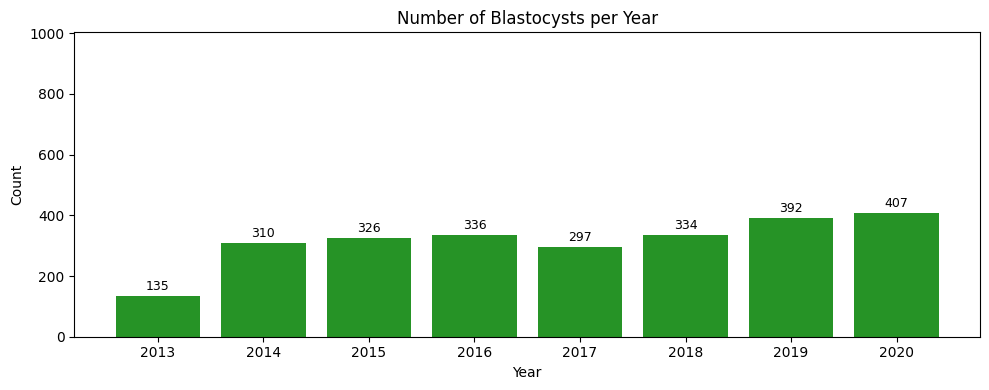

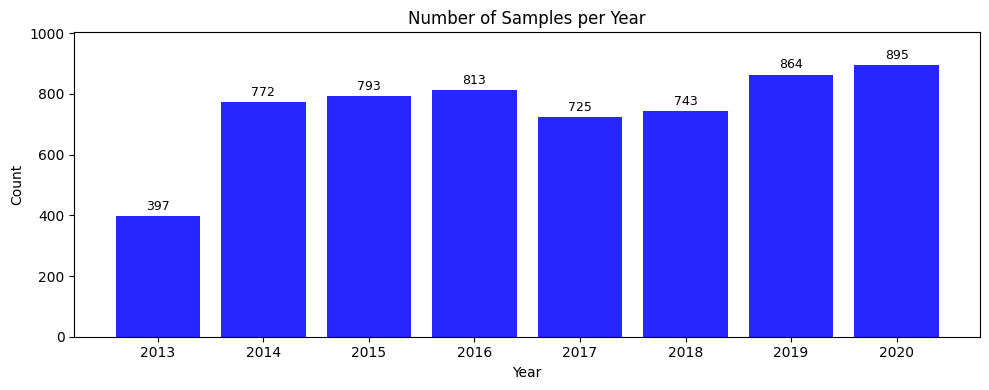

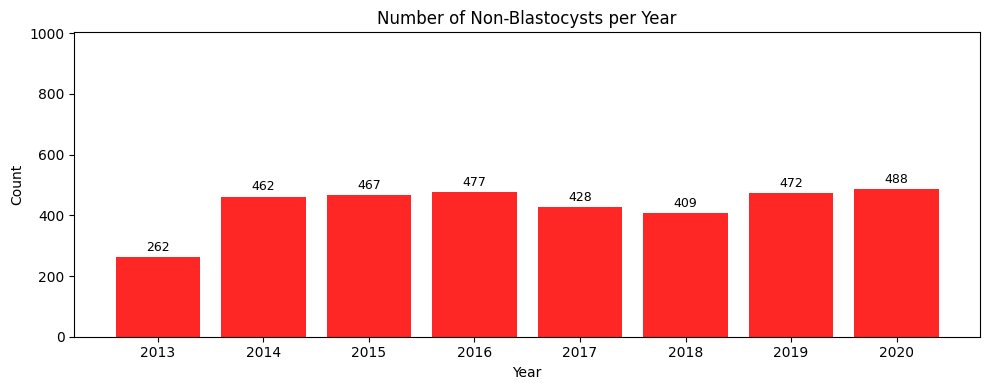

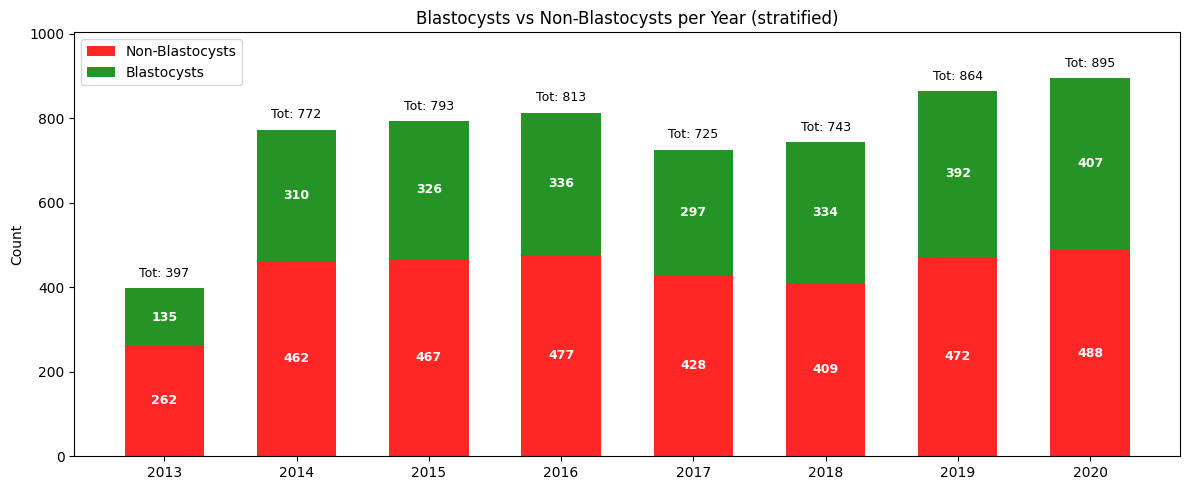

In [ ]:
# === A: Plots coerenti Y-scale + stacked per anno ===
import numpy as np

years = list(yearly_df['Year'].astype(str))
samples_vals = list(yearly_df['Samples'])
blast_vals = list(yearly_df['Blastocysts'])
nonblast_vals = list(yearly_df['Non-Blastocysts'])

# assicurati che le liste abbiano lunghezza coerente
assert len(years) == len(samples_vals) == len(blast_vals) == len(nonblast_vals), "yearly_df columns mismatch"

# global y limit (same for all 3 plots)
y_max = max(samples_vals + blast_vals + nonblast_vals) if (samples_vals or blast_vals or nonblast_vals) else 1
y_top = int(np.ceil(y_max * 1.12))

def draw_bar(ax, x, heights, title, color):
    bars = ax.bar(x, heights, color=color, alpha=0.85)
    ax.set_title(title)
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    ax.set_ylim(0, y_top)
    for bar, val in zip(bars, heights):
        ax.text(bar.get_x() + bar.get_width()/2, val + y_top*0.01, f'{int(val)}', ha='center', va='bottom', fontsize=9)

# Plot 1: Blastocysts per year (verde)
fig, ax = plt.subplots(figsize=(10,4))
draw_bar(ax, years, blast_vals, 'Number of Blastocysts per Year', color='green')
plt.tight_layout()
plt.show()

# Plot 2: Samples per year (blu)
fig, ax = plt.subplots(figsize=(10,4))
draw_bar(ax, years, samples_vals, 'Number of Samples per Year', color='blue')
plt.tight_layout()
plt.show()

# Plot 3: Non-blastocysts per year (rosso)
fig, ax = plt.subplots(figsize=(10,4))
draw_bar(ax, years, nonblast_vals, 'Number of Non-Blastocysts per Year', color='red')
plt.tight_layout()
plt.show()

# --- Additional: stacked/stratified bar per year (red = no_blasto, green = blasto) ---
import pandas as pd
ind = np.arange(len(years))
width = 0.6

fig, ax = plt.subplots(figsize=(12,5))
# disegno la porzione "no_blasto" come bottom
bars_no = ax.bar(ind, nonblast_vals, width, label='Non-Blastocysts', color='red', alpha=0.85)
# sopra metto i blastocysts
bars_b = ax.bar(ind, blast_vals, width, bottom=nonblast_vals, label='Blastocysts', color='green', alpha=0.85)

ax.set_xticks(ind)
ax.set_xticklabels(years)
ax.set_ylabel('Count')
ax.set_title('Blastocysts vs Non-Blastocysts per Year (stratified)')
ax.set_ylim(0, y_top)
ax.legend()

# annotazioni: per ogni segmento scrivo il valore relativo centrato nel segmento
for i in range(len(years)):
    # non-blasto segment
    h_no = nonblast_vals[i]
    if h_no > 0:
        ax.text(ind[i], h_no/2, f'{int(h_no)}', ha='center', va='center', color='white', fontsize=9, fontweight='bold')
    # blasto segment: pos = bottom + height/2
    h_b = blast_vals[i]
    if h_b > 0:
        ax.text(ind[i], nonblast_vals[i] + h_b/2, f'{int(h_b)}', ha='center', va='center', color='white', fontsize=9, fontweight='bold')

# annotazione totale sopra la barra
for rect, a, b in zip(bars_b, nonblast_vals, blast_vals):
    total = int(a + b)
    ax.text(rect.get_x() + rect.get_width()/2, a + b + y_top*0.02, f'Tot: {total}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


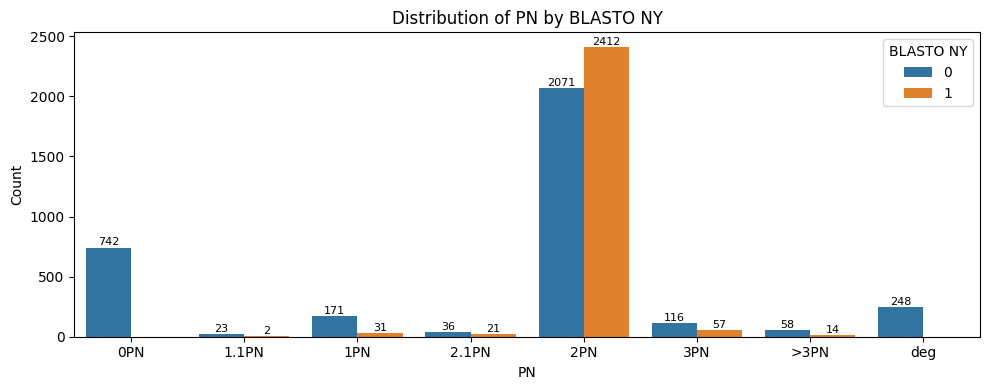


Counts (rows = PN type):


BLASTO NY,0,1
PN,,
0PN,742,0
1.1PN,23,2
1PN,171,31
2.1PN,36,21
2PN,2071,2412
3PN,116,57
>3PN,58,14
deg,248,0



Percentages (rows sum to 100%):


BLASTO NY,0,1
PN,,
0PN,100.00,0.00
1.1PN,92.00,8.00
1PN,84.65,15.35
2.1PN,63.16,36.84
2PN,46.20,53.80
3PN,67.05,32.95
>3PN,80.56,19.44
deg,100.00,0.00


In [34]:
# === C (aggiornato): PN plotting con dimensioni ridotte e annotazioni ===
import re
from IPython.display import display

def plot_pn_distribution_improved_small(df, target='BLASTO NY'):
    # Trova colonne PN candidate
    candidates = [c for c in df.columns if re.match(r'(?i)^pn(_|)(\d*).*', c)]
    for c in ['PN','pn','pn_type','PN_type','PNtype']:
        if c in df.columns and c not in candidates:
            candidates.append(c)
    candidates = sorted(set(candidates))

    # prefer single column
    single_pn_col = None
    for trycol in ['PN','pn','pn_type','PN_type','PNtype']:
        if trycol in df.columns:
            single_pn_col = trycol
            break

    if single_pn_col:
        col = single_pn_col
        plt.figure(figsize=(10,4))
        ax = sns.countplot(data=df, x=col, hue=target, order=sorted(df[col].dropna().astype(str).unique()))
        plt.title(f"Distribution of {col} by {target}")
        plt.xlabel(col)
        plt.ylabel("Count")

        # annota ogni barra con il valore esatto
        for p in ax.patches:
            h = int(p.get_height())
            if h > 0:
                ax.annotate(f'{h}', (p.get_x() + p.get_width()/2., h + 0.5), ha='center', va='bottom', fontsize=8)
        plt.tight_layout()
        plt.show()

        # tabella dei counts e percentuali
        counts = pd.crosstab(df[col].astype(str), df[target])
        pct = pd.crosstab(df[col].astype(str), df[target], normalize='index') * 100
        print("\nCounts (rows = PN type):")
        display(counts)
        print("\nPercentages (rows sum to 100%):")
        display(pct.round(2))

    elif candidates:
        pn_cols = candidates
        # melt in long format
        long = df.melt(id_vars=[target], value_vars=pn_cols, var_name='pn_col', value_name='pn_value')
        long = long[~long['pn_value'].isna()]
        long['pn_value'] = long['pn_value'].astype(str)
        if long.empty:
            print("No usable PN values after melt.")
            return

        plt.figure(figsize=(10,4))  # più compatta
        ax = sns.countplot(data=long, x='pn_value', hue=target, order=sorted(long['pn_value'].unique()))
        plt.title("PN values distribution (from PN columns) by BLASTO NY")
        plt.xlabel("PN value")
        plt.ylabel("Count")

        # annotazioni sulle barre (valori esatti)
        for p in ax.patches:
            h = int(p.get_height())
            if h > 0:
                ax.annotate(f'{h}', (p.get_x() + p.get_width()/2., h + 0.5), ha='center', va='bottom', fontsize=8)
        plt.tight_layout()
        plt.show()

        # counts and percentages
        counts = pd.crosstab(long['pn_value'], long[target])
        pct = pd.crosstab(long['pn_value'], long[target], normalize='index') * 100
        print("\nCounts (PN value x BLASTO NY):")
        display(counts)
        print("\nPercentages (PN value rows sum to 100%):")
        display(pct.round(2))
    else:
        print("No PN columns found. Indica il nome della colonna PN se diverso.")

# call
plot_pn_distribution_improved_small(df, target='BLASTO NY')



Normality tests for maternal age:
KS group0: D=0.1066, p=0.0000
KS group1: D=0.0879, p=0.0000
Shapiro group0: W=0.9645, p=0.0000
Shapiro group1: W=0.9737, p=0.0000
D'Agostino group0: stat=262.0677, p=0.0000
D'Agostino group1: stat=136.2887, p=0.0000


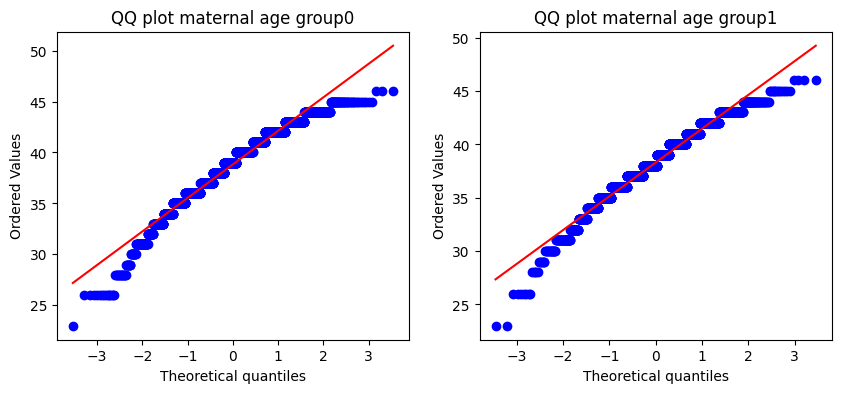

Mann-Whitney U: U=4850354.0000, p=5.472e-12
t-test: t=6.2655, p=3.994e-10
Point-biserial: r=-0.0801, p=5.154e-10

Categorical tests for sperm quality:
Chi2=26.6942, p=0.00511, CramersV=0.06668997100764269

Categorical tests for mezzo di coltura:
Chi2=16.0226, p=0.0003317, CramersV=0.05166762735788873


In [35]:
# Statistical tests: normality, Mann-Whitney, t-test, point-biserial, chi-square
import numpy as np
from scipy.stats import kstest, shapiro, normaltest, mannwhitneyu, ttest_ind, pointbiserialr, chi2_contingency
import matplotlib.pyplot as plt
from scipy.stats import probplot

continuous_columns = ['maternal age']
categorical_columns = ['sperm quality', 'mezzo di coltura']
target = 'BLASTO NY'

df_local = df.copy()
for col in continuous_columns:
    if col not in df_local.columns:
        print(f"Column {col} not in dataframe; skipping tests for it.")
    else:
        g1 = df_local[df_local[target]==0][col].dropna()
        g2 = df_local[df_local[target]==1][col].dropna()
        print(f"\nNormality tests for {col}:")
        if len(g1)>0 and len(g2)>0:
            ks1, p1 = kstest((g1-g1.mean())/g1.std(), 'norm')
            ks2, p2 = kstest((g2-g2.mean())/g2.std(), 'norm')
            print(f'KS group0: D={ks1:.4f}, p={p1:.4f}')
            print(f'KS group1: D={ks2:.4f}, p={p2:.4f}')
            sw1, sp1 = shapiro(g1) if len(g1)<=5000 else (None, None)
            sw2, sp2 = shapiro(g2) if len(g2)<=5000 else (None, None)
            if sw1 is not None:
                print(f'Shapiro group0: W={sw1:.4f}, p={sp1:.4f}')
                print(f'Shapiro group1: W={sw2:.4f}, p={sp2:.4f}')
            dp1, dpp1 = normaltest(g1) if len(g1)>8 else (None, None)
            dp2, dpp2 = normaltest(g2) if len(g2)>8 else (None, None)
            if dp1 is not None:
                print(f"D'Agostino group0: stat={dp1:.4f}, p={dpp1:.4f}")
                print(f"D'Agostino group1: stat={dp2:.4f}, p={dpp2:.4f}")

            # QQ plots
            fig = plt.figure(figsize=(10,4))
            ax = fig.add_subplot(121)
            probplot(g1, dist='norm', plot=ax)
            ax.set_title(f'QQ plot {col} group0')
            ax2 = fig.add_subplot(122)
            probplot(g2, dist='norm', plot=ax2)
            ax2.set_title(f'QQ plot {col} group1')
            plt.show()

            # Mann-Whitney
            u_stat, u_p = mannwhitneyu(g1, g2)
            print(f'Mann-Whitney U: U={u_stat:.4f}, p={u_p:.4g}')
            # t-test
            t_stat, t_p = ttest_ind(g1, g2, equal_var=False)
            print(f't-test: t={t_stat:.4f}, p={t_p:.4g}')
            # point-biserial (requires continuous col)
            try:
                corr, p_corr = pointbiserialr(df_local[target].dropna(), df_local[col].dropna())
                print(f'Point-biserial: r={corr:.4f}, p={p_corr:.4g}')
            except Exception as e:
                print('Point-biserial error:', e)
        else:
            print('Not enough data for groups to perform continuous-variable tests')

for col in categorical_columns:
    if col not in df_local.columns:
        print(f"Column {col} not in dataframe; skipping categorical tests for it.")
    else:
        print(f"\nCategorical tests for {col}:")
        contingency = pd.crosstab(df_local[col], df_local[target])
        if contingency.values.sum() == 0:
            print('Empty contingency table')
            continue
        chi2, p, dof, expected = chi2_contingency(contingency)
        n = contingency.values.sum()
        k = min(contingency.shape)-1 if min(contingency.shape)>0 else 1
        cramers_v = (chi2/(n*k))**0.5 if n>0 and k>0 else None
        print(f'Chi2={chi2:.4f}, p={p:.4g}, CramersV={cramers_v}')


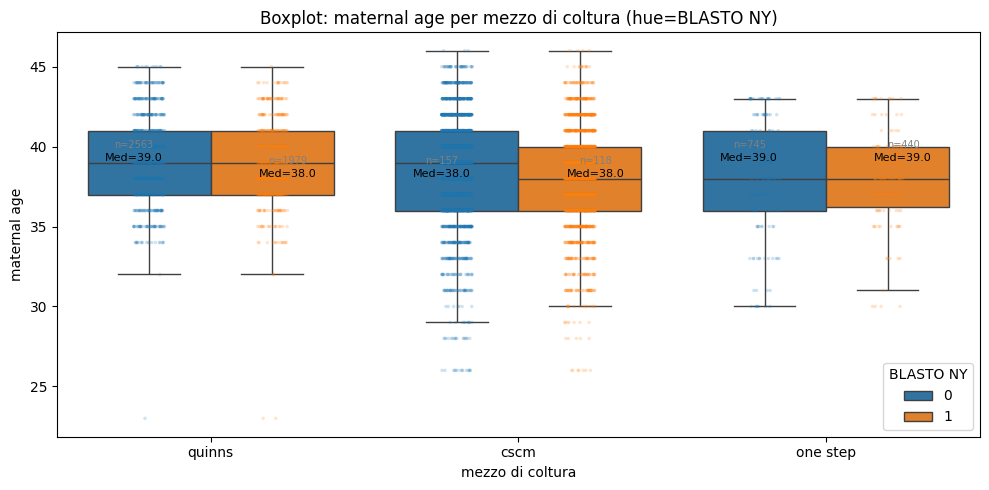

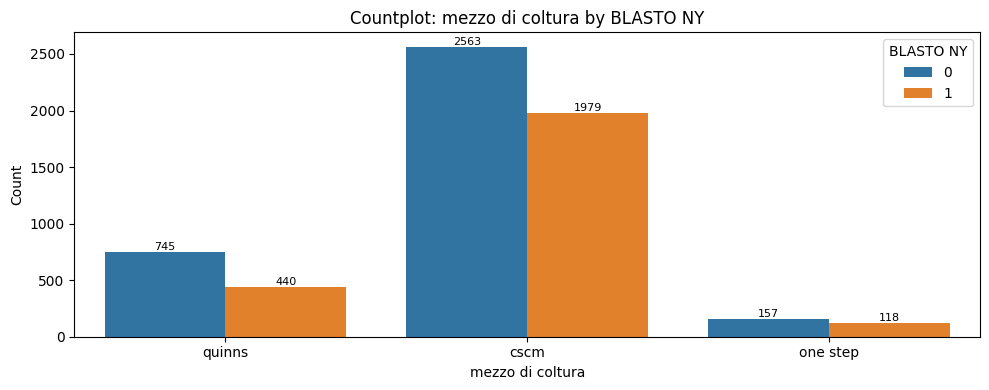

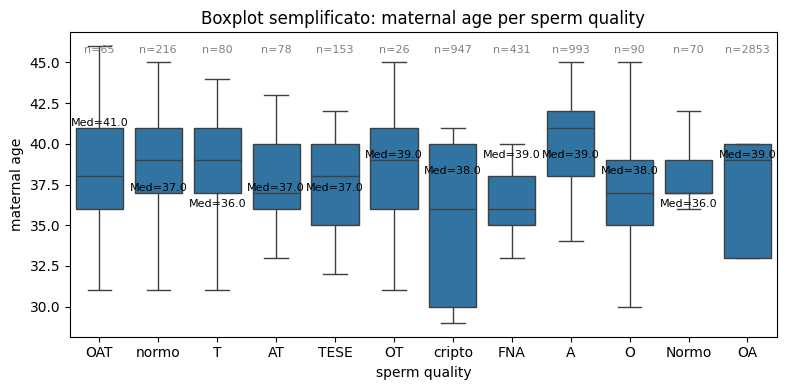

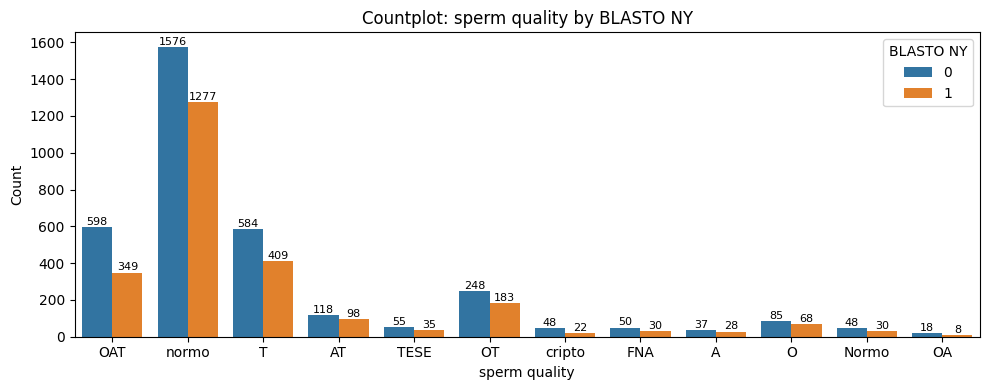

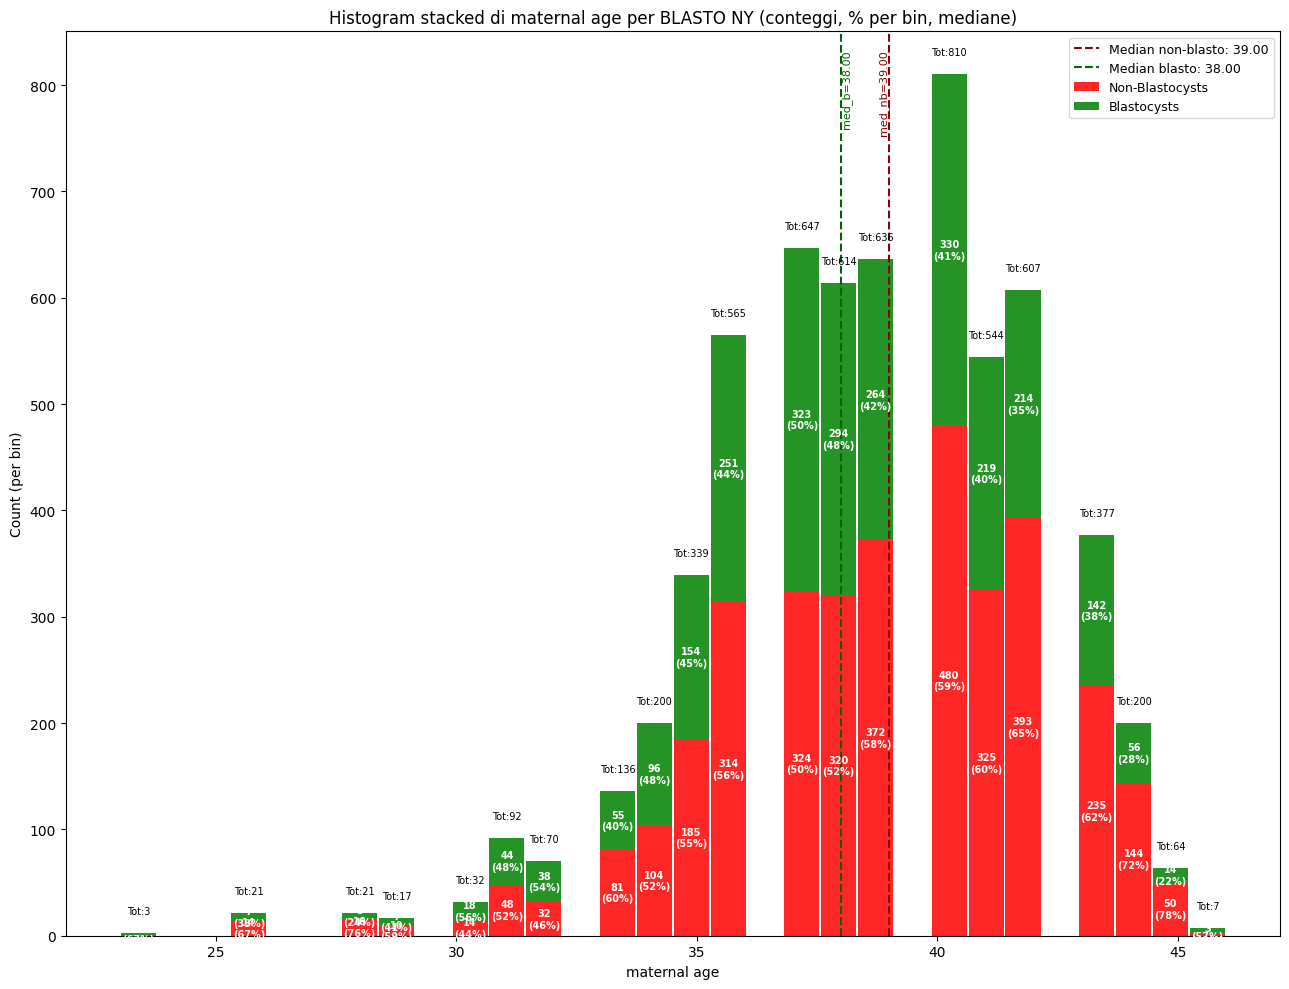

Summary:
 Total samples (maternal age available): 6002
 Blastocysts: 2537  | median = 38.0
 Non-Blastocysts: 3465 | median = 39.0


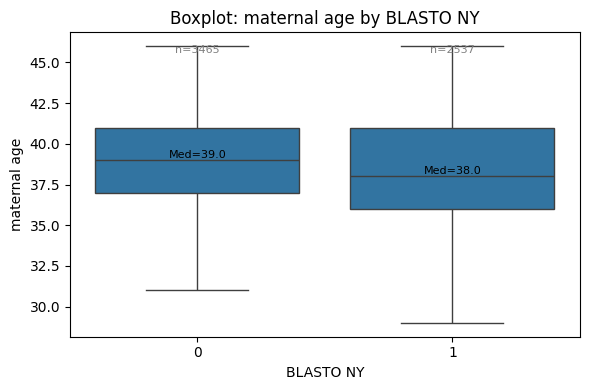

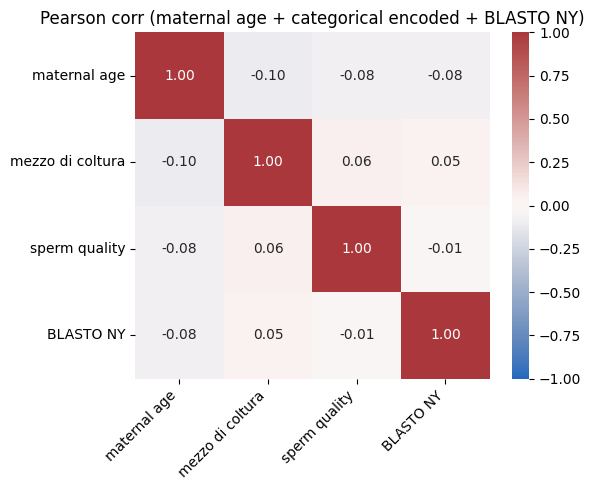

In [42]:
# === B (finale): boxplot semplificati, histogram stratificato, boxplot target vs maternal age, heatmap ===
import seaborn as sns
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt

cat_vars = ['mezzo di coltura', 'sperm quality']
cont_var = 'maternal age'
target = 'BLASTO NY'

# safe checks
if cont_var not in df.columns:
    print(f"Warning: '{cont_var}' non presente nel dataframe — alcune figure non saranno mostrate.")

# Loop sulle categorical richieste
for col in cat_vars:
    if col not in df.columns:
        print(f"Warning: column '{col}' not found in dataframe, skipping.")
        continue

    #################################################################
    # A) Boxplot: comportamento differenziato per 'sperm quality' (più semplice)
    #################################################################
    if cont_var in df.columns:
        if col == 'sperm quality':
            # boxplot semplificato: solo box senza outliers e annotazioni mediane/n
            plt.figure(figsize=(8,4))
            ax = sns.boxplot(data=df, x=col, y=cont_var, showfliers=False)
            ax.set_title(f'Boxplot semplificato: {cont_var} per {col}')
            ax.set_xlabel(col)
            ax.set_ylabel(cont_var)

            # annotate median and count for each category
            categories = [str(x) for x in sorted(df[col].dropna().unique())]
            for i, cat in enumerate(categories):
                vals = df[df[col].astype(str) == cat][cont_var].dropna()
                if len(vals) == 0:
                    continue
                median = vals.median()
                n = len(vals)
                # x position = i (box centers)
                ax.text(i, median, f'Med={median:.1f}', ha='center', va='bottom', fontsize=8)
                ax.text(i, ax.get_ylim()[1] - (ax.get_ylim()[1]-ax.get_ylim()[0])*0.04, f'n={n}', 
                        ha='center', va='top', fontsize=8, color='gray')
            plt.tight_layout()
            plt.show()

        else:
            # mezzo di coltura: boxplot con hue=target ma non troppo affollato
            plt.figure(figsize=(10,5))
            ax = sns.boxplot(data=df, x=col, y=cont_var, hue=target, showfliers=False)
            # leggera jitter per vedere densità, alfa basso
            sns.stripplot(data=df, x=col, y=cont_var, hue=target, dodge=True, marker='.', alpha=0.2, ax=ax, linewidth=0)
            # rimuovo la seconda legenda generata dal stripplot
            handles, labels = ax.get_legend_handles_labels()
            if len(handles) >= 2:
                ax.legend(handles[:2], labels[:2], title=target)

            ax.set_title(f'Boxplot: {cont_var} per {col} (hue={target})')
            ax.set_xlabel(col)
            ax.set_ylabel(cont_var)

            # annotate median and n per (category, target)
            stats = df.groupby([col, target])[cont_var].agg(['median','count']).reset_index()
            categories = sorted(df[col].dropna().astype(str).unique())
            hue_vals = sorted(df[target].dropna().unique())
            n_hue = len(hue_vals)
            # simple offsets to place annotations near each box: small relative offsets
            offsets = np.linspace(-0.25, 0.25, max(1,n_hue))
            for i, cat in enumerate(categories):
                for j, h in enumerate(hue_vals):
                    row = stats[(stats[col].astype(str) == str(cat)) & (stats[target] == h)]
                    if row.empty:
                        continue
                    median = row['median'].values[0]
                    count = int(row['count'].values[0])
                    xpos = i + offsets[j]
                    ax.text(xpos, median, f'Med={median:.1f}', ha='center', va='bottom', fontsize=8)
                    ax.text(xpos, median + (ax.get_ylim()[1]-ax.get_ylim()[0])*0.03, f'n={count}', ha='center', va='bottom', fontsize=7, color='gray')

            plt.tight_layout()
            plt.show()
    else:
        print(f"Column {cont_var} missing; skipping boxplot for {col}.")

    #################################################################
    # B) Countplot per categoria (semplice) con annotazioni
    #################################################################
    plt.figure(figsize=(10,4))
    ax = sns.countplot(data=df, x=col, hue=target)
    ax.set_title(f'Countplot: {col} by {target}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    # annotazioni semplici sopra le barre
    for p in ax.patches:
        height = int(p.get_height())
        if height > 0:
            ax.annotate(f'{height}', (p.get_x() + p.get_width()/2., height + 0.5),
                        ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

#################################################################
# C) Histogram stratificato per maternal age (stacked) - BLASTO vs NO_BLASTO
#################################################################
import numpy as np
import matplotlib.pyplot as plt

if cont_var in df.columns and target in df.columns:
    # usare booleano per definire gruppi: True = blastocyst (assumo valore 1), False = no_blasto
    # fallback: consideriamo "==1" come blasto, altrimenti prendiamo il valore più frequente come no-blasto
    try:
        is_blast = df[target] == 1
        if is_blast.sum() == 0:
            # se non ci sono 1, prendi il valore max come blast
            max_val = df[target].dropna().max()
            is_blast = df[target] == max_val
    except Exception:
        is_blast = df[target].astype(str) == '1'

    vals_all = df[cont_var].dropna()
    vals_blast = df.loc[is_blast, cont_var].dropna()
    vals_noblast = df.loc[~is_blast, cont_var].dropna()

    if len(vals_all) == 0:
        print("Nessun dato disponibile per l'istogramma.")
    else:
        # bins coerenti
        bins = np.histogram_bin_edges(vals_all, bins=30)
        nbins = len(bins) - 1
        # hist per gruppo con gli stessi bins
        hist_noblast, _ = np.histogram(vals_noblast, bins=bins)
        hist_blast, _ = np.histogram(vals_blast, bins=bins)
        bin_centers = (bins[:-1] + bins[1:]) / 2.0
        width = bins[1] - bins[0]

        # plot stacked bars: noblast (bottom) then blast (top)
        fig, ax = plt.subplots(figsize=(13,10))
        bars_n = ax.bar(bin_centers, hist_noblast, width=width*0.95, align='center', label='Non-Blastocysts', color='red', alpha=0.85)
        bars_b = ax.bar(bin_centers, hist_blast, width=width*0.95, bottom=hist_noblast, align='center', label='Blastocysts', color='green', alpha=0.85)

        # annotazioni per ogni segmento: count e percentuale (sul bin)
        total_per_bin = hist_noblast + hist_blast
        for i in range(nbins):
            # non-blast segment
            h_n = int(hist_noblast[i])
            h_b = int(hist_blast[i])
            tot = int(total_per_bin[i])
            if tot == 0:
                continue
            # percentuale sul bin (per segmento)
            pct_n = 100 * h_n / tot if tot > 0 else 0.0
            pct_b = 100 * h_b / tot if tot > 0 else 0.0

            # annotate non-blast (posizione metà segmento)
            if h_n > 0:
                ax.text(bin_centers[i], h_n/2.0, f'{h_n}\n({pct_n:.0f}%)', ha='center', va='center', fontsize=7, color='white', fontweight='bold')
            # annotate blast (posizione metà segmento)
            if h_b > 0:
                ax.text(bin_centers[i], h_n + h_b/2.0, f'{h_b}\n({pct_b:.0f}%)', ha='center', va='center', fontsize=7, color='white', fontweight='bold')

            # annotate total above bar
            ax.text(bin_centers[i], tot + max(1, int(0.02 * (hist_noblast.max() + hist_blast.max()))), f'Tot:{tot}', ha='center', va='bottom', fontsize=7, color='black')

        # mediane per gruppo (vertical lines)
        med_blast = vals_blast.median() if len(vals_blast)>0 else np.nan
        med_noblast = vals_noblast.median() if len(vals_noblast)>0 else np.nan
        ylim = ax.get_ylim()
        # plot median lines and annotate
        if not np.isnan(med_noblast):
            ax.axvline(med_noblast, color='darkred', linestyle='--', linewidth=1.5, label=f'Median non-blasto: {med_noblast:.2f}')
            ax.text(med_noblast, ylim[1]*0.98, f'med_nb={med_noblast:.2f}', color='darkred', ha='right', va='top', fontsize=8, rotation=90)
        if not np.isnan(med_blast):
            ax.axvline(med_blast, color='darkgreen', linestyle='--', linewidth=1.5, label=f'Median blasto: {med_blast:.2f}')
            ax.text(med_blast, ylim[1]*0.98, f'med_b={med_blast:.2f}', color='darkgreen', ha='left', va='top', fontsize=8, rotation=90)

        ax.set_title(f'Histogram stacked di {cont_var} per {target} (conteggi, % per bin, mediane)')
        ax.set_xlabel(cont_var)
        ax.set_ylabel('Count (per bin)')
        ax.legend(loc='upper right', fontsize=9)
        plt.tight_layout()
        plt.show()

        # stampa sommario mediana e conteggi totali
        print("Summary:")
        print(f" Total samples (maternal age available): {len(vals_all)}")
        print(f" Blastocysts: {len(vals_blast)}  | median = {med_blast if not np.isnan(med_blast) else 'NA'}")
        print(f" Non-Blastocysts: {len(vals_noblast)} | median = {med_noblast if not np.isnan(med_noblast) else 'NA'}")
else:
    print("Skipping histogram stratificato: manca 'maternal age' o 'BLASTO NY'.")

#################################################################
# D) Boxplot semplice: maternal age (y) vs BLASTO NY (x)
#################################################################
if cont_var in df.columns and target in df.columns:
    plt.figure(figsize=(6,4))
    ax = sns.boxplot(data=df, x=target, y=cont_var, showfliers=False)
    ax.set_title(f'Boxplot: {cont_var} by {target}')
    ax.set_xlabel(target)
    ax.set_ylabel(cont_var)
    # annota mediana e n per gruppo
    groups = sorted(df[target].dropna().unique())
    for i, g in enumerate(groups):
        vals = df[df[target] == g][cont_var].dropna()
        if len(vals) == 0:
            continue
        median = vals.median()
        n = len(vals)
        ax.text(i, median, f'Med={median:.1f}', ha='center', va='bottom', fontsize=8)
        ax.text(i, ax.get_ylim()[1] - (ax.get_ylim()[1]-ax.get_ylim()[0])*0.04, f'n={n}', ha='center', va='top', fontsize=8, color='gray')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping boxplot BLASTO NY vs maternal age: colonne mancanti.")

#################################################################
# E) Heatmap ristretta: maternal age + mezzo di coltura (code) + sperm quality (code) + BLASTO NY (code)
#################################################################
heat_cols = []
if cont_var in df.columns:
    heat_cols.append(cont_var)

# codifica categoriali: factorize (non modifica le colonne originali)
for c in cat_vars:
    if c in df.columns:
        df[f'{c}__code'] = pd.factorize(df[c].astype(str))[0]
        heat_cols.append(f'{c}__code')

if target in df.columns:
    # preferisci numeric 0/1, altrimenti factorize
    try:
        df[f'{target}__code'] = pd.to_numeric(df[target])
    except:
        df[f'{target}__code'] = pd.factorize(df[target].astype(str))[0]
    heat_cols.append(f'{target}__code')

# filtra e calcola correlazione
heat_cols = [c for c in heat_cols if c in df.columns]
if len(heat_cols) >= 2:
    corr_df = df[heat_cols].copy().dropna()
    corr = corr_df.corr(method='pearson')

    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0, vmin=-1, vmax=1)
    # rendere le etichette umane
    new_labels = [col.replace('__code','') for col in corr.columns]
    plt.xticks(ticks=np.arange(len(new_labels))+0.5, labels=new_labels, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(new_labels))+0.5, labels=new_labels, rotation=0)
    plt.title('Pearson corr (maternal age + categorical encoded + BLASTO NY)')
    plt.tight_layout()
    plt.show()
else:
    print("Non ci sono abbastanza colonne per la heatmap ristretta.")

Possibile spiegazione risultati:
- Il t-test confronta le medie di due gruppi e, con campioni grandi, anche piccole differenze tra i gruppi possono 
risultare statisticamente significative se la variabilità all'interno dei gruppi è bassa.
Nel caso di questi dati, non essendo distribuiti normalmente (o almeno, questo dicono i test statistici), 
non uso il t-test ma il mann-whitney U, ma le idee di base sono le stesse (troppi campioni forse)

- Con campioni molto grandi, i test di normalità hanno una potenza elevata e possono rilevare deviazioni minime 
dalla normalità che non sono visibili nei QQ plot.


Per questi motivi, oltre a considerare il p-value, considero anche altri parametri, come l'effect-size.
Per il Mann-Whitney U test, una misura comune dell'effect size è Cohen's d o r. L'effect size r per il 
Mann-Whitney U test può essere calcolato come segue: r = Z/sqrt(N)
Z è la statistica Z trasformata dalla statistica U. N è il numero totale di osservazioni.

Considero in generale la divisione:
0.1: Small effect
0.3: Medium effect
0.5: Large effect
Mentre il p-value ti dice se c'è una differenza statisticamente significativa tra i gruppi, l'effect size ti dice 
quanto è grande questa differenza, che è particolarmente utile per interpretare i risultati in studi con grandi 
campioni.

Infine, considero la point-biserial correlation per determinare se la correlazione tra maternal age ed output è forte.
La correlazione point-biseriale è una misura di correlazione che si applica quando si ha una variabile dicotomica (binaria) 
e una variabile continua. È una versione speciale del coefficiente di correlazione di Pearson.

Il risultato è che l'età materna ha un effetto minimo sull'output "BLASTO NY" e non dovrebbe essere considerata un 
fattore determinante principale per l'output. 

NB: Entrambe le misure forniscono informazioni utili ma complementari: la correlazione dice quanto sono linearmente associate
    le variabili, mentre l'effect size dice quanto grande è la differenza osservata o l'effetto nel contesto dello studio.



Per le variabili categoriche, una misura comune dell'effect size è Cramér's V. Questo valore è derivato dalla 
statistica Chi-quadro e fornisce una misura della forza dell'associazione tra le variabili categoriche

V=sqrt( (chi^2)/ N⋅(k-1) )

Posso fare un ragionamento simile anche per il kstest, anche se non fornisce un effetto delle dimensioni 
diretto come Cramér's V. Tuttavia possiamo considerare il valore D del KS test rappresenta la distanza massima 
tra la funzione di distribuzione empirica (ECDF) e la funzione di distribuzione cumulativa (CDF) teorica. 
Anche se non è un vero e proprio effetto delle dimensioni, il valore D può essere utilizzato per avere un'idea 
dell'effetto.

Linee guida:
    0 ≤ D < 0.1: Piccola differenza (molto vicina alla distribuzione teorica).
    0.1 ≤ D < 0.2: Differenza moderata.
    D ≥ 0.2: Grande differenza (significativa deviazione dalla distribuzione teorica).